In [1]:
# Numpy imports:
import numpy as np

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
#Data Params:
#Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2
frame_int = 20 #s
ATPconc = 470 #uM
Motconc = 1 #uM
skip_int = 10 #data frames to skip 

In [4]:
#This should not change between experiments:
datapath = '../../data/atp_hydro'
#This varies between experiments.  
datafolder = '2023-11-24_Hydrolysis_QueenA81D/1_ADP_variation_at_500uMATP/Nikon_10X_bin1_20sFrameInterval__100ms480_150ms405_500uATP_1uMmicro_1400nM_A81D_1/470uMADP_1'
datafolder = '2023-11-24_Hydrolysis_QueenA81D/1_ADP_variation_at_500uMATP/Nikon_10X_bin1_20sFrameInterval__100ms480_150ms405_500uATP_1uMmicro_1400nM_A81D_1/470uMADP_1'

#--------- Read in Files -----------#
# bound Images
included_bound = '*405*.tif'
bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))[::skip_int]

# unbound Images
included_unbound = '*480*.tif'
unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))[::skip_int]
#--------------

# Convert files to images and save as array:
bound_array = atp_hydro.file_to_image(bound_files)
unbound_array = atp_hydro.file_to_image(unbound_files)

# ------------------------------------------------------------------------------ #
#Background 
bound_bg = 1914
unbound_bg = 1914

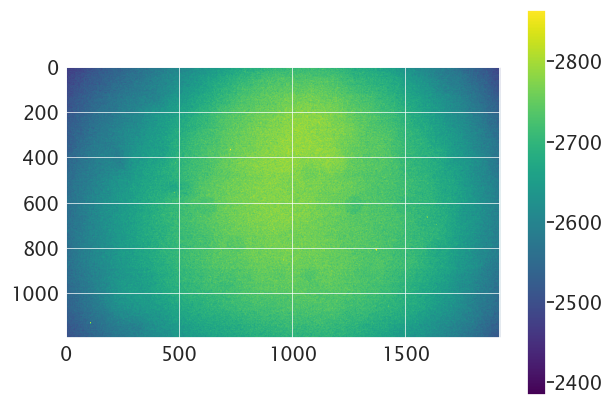

In [5]:
samp_im = bound_array[10]
plt.imshow(samp_im, vmin=np.percentile(samp_im, 0), vmax=np.percentile(samp_im,99.99))
plt.colorbar()

In [6]:
#Subtract im_dark from all calibration images
bound_bs = bound_array - bound_bg
unbound_bs = unbound_array - unbound_bg

#set negative values to zero
unbound_bs[unbound_bs<0] = 0
bound_bs[bound_bs<0] = 0

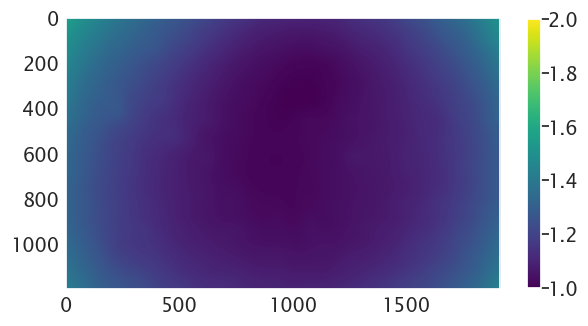

In [7]:
#Find the normilization matrix
bound_norm_mat = atp_hydro.norm_mat_fn_iATP(bound_array[-1], bound_bg)
unbound_norm_mat = atp_hydro.norm_mat_fn_iATP(unbound_array[-1], unbound_bg)

#plot the normalizaiton matrix
plt.imshow(bound_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [8]:
#Normalize all the claibration images by multiplying by the normalization matrix
bound_norm = bound_bs*bound_norm_mat
unbound_norm = unbound_bs*unbound_norm_mat

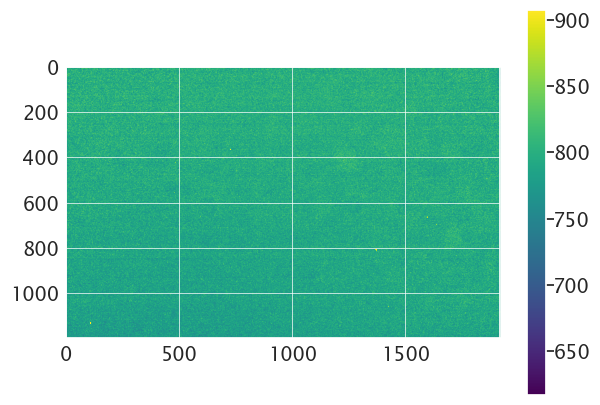

In [9]:
samp_im = bound_norm[50]
plt.imshow(samp_im, vmin=np.percentile(samp_im, 0), vmax = np.percentile(samp_im, 99.99))
plt.colorbar()

In [10]:
#Average intensities
bound_hydro = np.average(bound_norm, axis=(1,2))
unbound_hydro = np.average(unbound_norm, axis=(1,2))
ratio_hydro = bound_hydro/unbound_hydro

In [11]:
time = np.arange(0, len(ratio_hydro), 1)*frame_int*skip_int #s

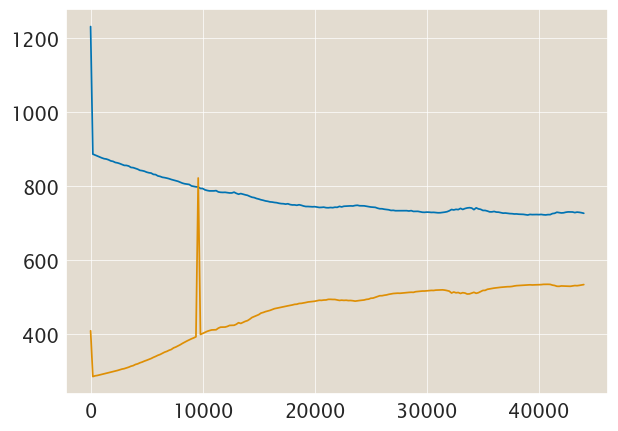

In [12]:
plt.plot(time, bound_hydro)
plt.plot(time, unbound_hydro)

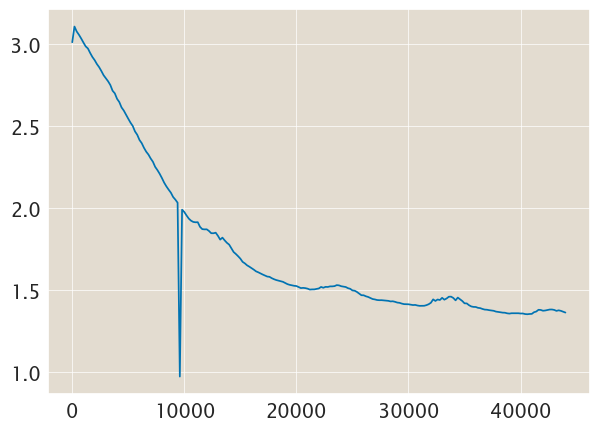

In [13]:
plt.plot(time, ratio_hydro)

In [14]:
def ATP_inten_to_conc(array, a, b, c, d):
    return a * ((c - array) / (array - b)) ** (1/d)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_32444/1203200823.py:2: RuntimeWarning: invalid value encountered in power
  return a * ((c - array) / (array - b)) ** (1/d)


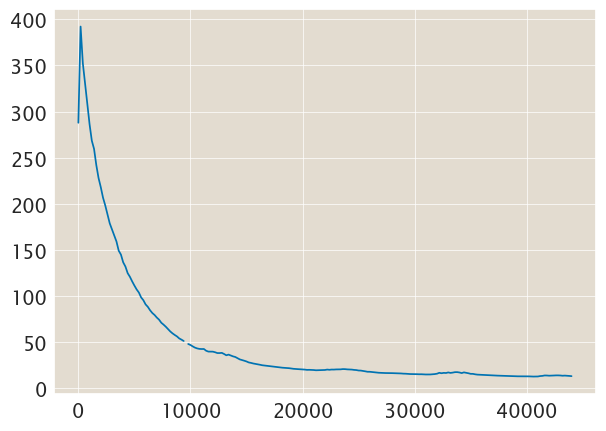

In [15]:
ratio_concavg = ATP_inten_to_conc(ratio_hydro, 67.60201128,  3.36417414,  1.06783864,  1.17289855)
plt.plot(time, ratio_concavg)

In [16]:
#Remove any nans

#find nans
nans = np.where(np.isnan(ratio_concavg)==True)

#remove
ratio_hydro_uM = np.delete(ratio_concavg, nans)
times = np.delete(time, nans)

In [17]:
def rsqrd(data, fit):
    ssres = np.sum((data - fit)**2)
    sstot = np.sum((data-np.average(data))**2)
    return 1 - ssres/sstot

In [18]:
def expfunc(time, tau, Ao):
    return (Ao)*np.exp(-time/tau)
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(2), np.ones([2])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1])
    
    return param, curve

-2.6740321693340237


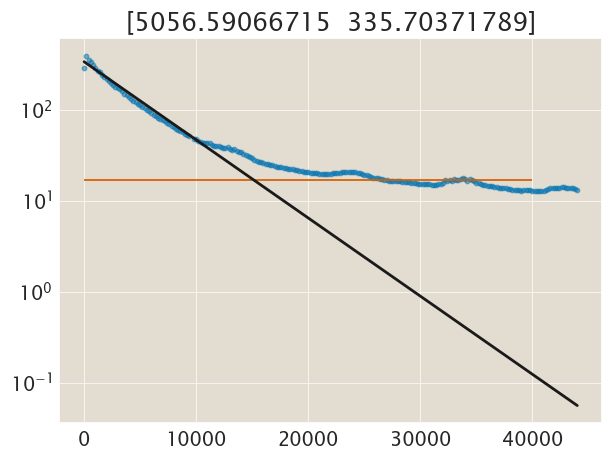

In [19]:
params, curve = expfit(times, ratio_hydro_uM, [2000, 500])
plt.scatter(times, ratio_hydro_uM, alpha=0.5, s=10)
plt.plot(times, curve, color='k', linewidth=2)
plt.title(str(params))
e3 = np.where(ratio_hydro_uM >= (params[1])/np.e**3)[-1][-1]
plt.hlines((params[1])/np.e**3, 0, 40000, color='r')
plt.yscale('log')
#plt.ylim(1, 300);
print(rsqrd(np.log(ratio_hydro_uM[:e3]), np.log(curve[:e3])))

In [20]:
def expfunc(time, tau, Ao, Ainf):
    return (Ao-Ainf)*np.exp(-time/tau) + Ainf
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1], param[2])
    
    return param, curve

In [21]:
params[1]/np.e**2

45.43255774375431

0.9919076762401595


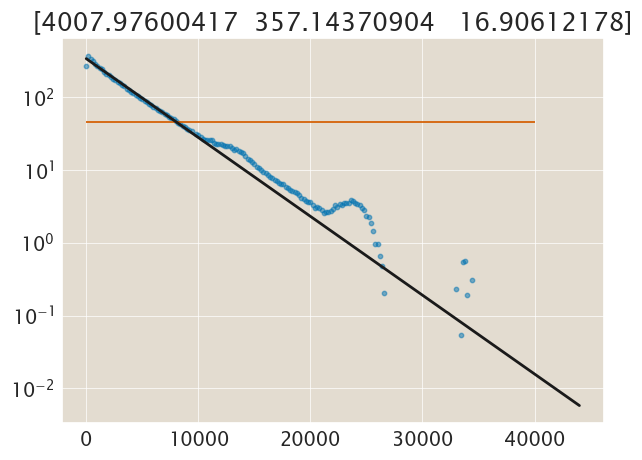

In [24]:
params, curve = expfit(times, ratio_hydro_uM, [2000, 500, 5])
e2 = np.where(ratio_hydro_uM-params[2] <= (params[1]-params[2])/np.e**2)[-1][0]

plt.scatter(times, ratio_hydro_uM-params[2], alpha=0.5, s=10)
plt.plot(times, curve-params[2], color='k', linewidth=2)
plt.title(str(params))
plt.hlines((params[1]-params[2])/np.e**2, 0, 40000, color='r')
plt.yscale('log')
#plt.ylim(1, 300);
print(rsqrd(np.log(ratio_hydro_uM[:e2]-params[2]), np.log(curve[:e2]-params[2])))

In [66]:
ratio_hydro_uM[:e2]-params[2]

array([270.96545271, 375.27124642, 335.45828531, 313.20809776,
       290.7900951 , 269.41119249, 251.58837357, 242.62691154,
       225.19005162, 211.14012265, 201.14305997, 189.73965407,
       181.31723541, 171.58740755, 161.88892821, 155.4227156 ,
       149.28820573, 142.22137121, 132.24928361, 127.98109513,
       119.62894267, 115.03339703, 107.86798713, 103.9290436 ,
        98.96949608,  94.44564205,  90.23569293,  86.84648954,
        81.59052433,  78.52416431,  73.99159816,  71.33514479,
        67.62200668,  64.65518743,  62.51987521,  59.72656937,
        57.46555692,  54.11257143,  52.07720354,  49.81457312,
        47.31071955])

In [67]:
e3 = np.where(ratio_hydro_uM >= (params[1]-params[2])/np.e**3)[-1][-1]
rsqrd(np.log(ratio_hydro_uM[:e3]), np.log(curve[:e3]))

0.9887324528028757

We model the ATP hydrolysis as an exponential decay
$$A = (A_0 - A_\infty)e^{-t/\tau} + A_\infty$$
Taking the taylor approximation to examine the linear region where t is small
$$A \approx (A_0 - A_\infty)\cdot \left( 1 -\frac{t}{\tau} + ... \right) + A_\infty$$
This is in the form of $A=mx+b$ where the slope, $m$, is the hydrolysis rate in ATPs per second for all motors in the experiment
$$A = A_0-(A_0 - A_\infty)\frac{t}{\tau} $$


In [68]:
ATPsat = params[1]-params[2] #uM
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/Motconc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.08489012581507849


In [ ]:
df_anal = pd.DataFrame({'ATP (uM)' : ,
                        'ADP (uM)' : ,
                        'P (uM)' : ,
                        'Motor (uM)' : ,
                        'Tau (s)' : params[0],
                        'A0 (uM)' : params[1],
                        'Ainf (uM)' : params[2],
                        'r-squared' : r2,
                        'hydro' : rate,
                        'Param' : ['Km', 'Rmax', 'Rmin', 'n'],
                        'Value' : params})
#df_fit.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_fit')

df_data = pd.DataFrame({'time (s)' : times, 'ATP (uM)' : ratio_hydro_uM})
#df_data.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_data')